In [1]:
# =============================================
# BLOCK 0: Notebook Setup & Imports
# =============================================
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from pathlib import Path

# -------------------------------------------------
# Paths (adjust only if your folder layout differs)
# -------------------------------------------------
DATA_ROOT = 'nutrition5k_dataset'
META_PATH = os.path.join(DATA_ROOT, 'metadata', 'dish_metadata_cafe1.csv')
IMG_ROOT  = os.path.join(DATA_ROOT, 'imagery', 'realsense_overhead')

# -------------------------------------------------
# Device
# -------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# =============================================
# BLOCK 1: Load & Clean Metadata + 3-Way Split
# =============================================
print('Loading metadata...')
df = pd.read_csv(META_PATH, header=None, index_col=0, on_bad_lines='skip')
print(f'Raw dishes: {len(df)}')

# Keep only dishes that have an image folder
existing_folders = set(os.listdir(IMG_ROOT))
df = df[df.index.isin(existing_folders)].copy()
print(f'After folder check: {len(df)} dishes with image folders')

# ---- 70 % train | 15 % val | 15 % test ----
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)
val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=42)

print(f'Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}')

Loading metadata...
Raw dishes: 4392
After folder check: 2898 dishes with image folders
Train: 2028 | Val: 435 | Test: 435


In [4]:
# =============================================
# BLOCK 2: Nutrition5kDataset (validation + resize)
# =============================================
def resize_to_multiple(tensor, mul=32):
    """Pad/interpolate H,W to be divisible by `mul` (UNet stride)."""
    _, h, w = tensor.shape
    nh = ((h + mul - 1) // mul) * mul
    nw = ((w + mul - 1) // mul) * mul
    if nh != h or nw != w:
        tensor = tensor.unsqueeze(0)                     # [1,C,H,W]
        tensor = F.interpolate(tensor, size=(nh, nw),
                               mode='bilinear', align_corners=False)
        tensor = tensor.squeeze(0)
    return tensor


class Nutrition5kDataset(Dataset):
    def __init__(self, df, img_root):
        self.img_root = img_root
        self.ids = self._validate(df)
        print(f'Valid samples: {len(self.ids)}')

    def _validate(self, df):
        good = []
        print('Validating image files... (this may take a moment)')
        for dish_id in df.index:
            rgb_path = os.path.join(self.img_root, dish_id, 'rgb.png')
            dep_path = os.path.join(self.img_root, dish_id, 'depth_raw.png')
            try:
                if (cv2.imread(rgb_path) is not None and
                    cv2.imread(dep_path, cv2.IMREAD_UNCHANGED) is not None):
                    good.append(dish_id)
            except Exception:
                continue
        return good

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        dish_id = self.ids[idx]

        # ---- Load images ----
        rgb = cv2.cvtColor(cv2.imread(os.path.join(self.img_root, dish_id, 'rgb.png')),
                           cv2.COLOR_BGR2RGB)                     # H×W×3
        dep = cv2.imread(os.path.join(self.img_root, dish_id, 'depth_raw.png'),
                         cv2.IMREAD_UNCHANGED).astype(np.float32)   # H×W (uint16)

        # ---- To torch ----
        rgb = torch.from_numpy(rgb.transpose(2, 0, 1)).float() / 255.0   # C×H×W, [0,1]
        dep = torch.from_numpy(dep).unsqueeze(0).float() / 1000.0       # 1×H×W, mm→m

        # ---- Resize for UNet stride ----
        rgb = resize_to_multiple(rgb, 32)
        dep = resize_to_multiple(dep, 32)

        return rgb, dep

In [5]:
# =============================================
# BLOCK 3: Datasets & DataLoaders
# =============================================
train_set = Nutrition5kDataset(train_df, IMG_ROOT)
val_set   = Nutrition5kDataset(val_df,   IMG_ROOT)
test_set  = Nutrition5kDataset(test_df,  IMG_ROOT)

BATCH_SIZE = 4
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f'Batches → Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}')

Validating image files... (this may take a moment)


[ WARN:0@149.065] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@163.452] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@167.953] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity


Valid samples: 2024
Validating image files... (this may take a moment)
Valid samples: 435
Validating image files... (this may take a moment)
Valid samples: 435
Batches → Train: 506 | Val: 109 | Test: 109


In [6]:
# =============================================
# BLOCK 4: ResNet-50 U-Net Model
# =============================================
class ResNetUNet(nn.Module):
    def __init__(self):
        super().__init__()
        res = models.resnet50(weights='IMAGENET1K_V2')

        # Encoder
        self.enc0 = nn.Sequential(res.conv1, res.bn1, res.relu)
        self.pool = res.maxpool
        self.e1, self.e2, self.e3, self.e4 = res.layer1, res.layer2, res.layer3, res.layer4

        # Decoder (skip connections)
        self.up4 = nn.ConvTranspose2d(2048, 1024, 2, 2); self.c4 = nn.Sequential(nn.Conv2d(2048,1024,3,1,1), nn.ReLU(True))
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, 2);  self.c3 = nn.Sequential(nn.Conv2d(1024,512,3,1,1), nn.ReLU(True))
        self.up2 = nn.ConvTranspose2d(512, 256, 2, 2);   self.c2 = nn.Sequential(nn.Conv2d(512,256,3,1,1), nn.ReLU(True))
        self.up1 = nn.ConvTranspose2d(256, 64, 2, 2);    self.c1 = nn.Sequential(nn.Conv2d(128,64,3,1,1), nn.ReLU(True))
        self.up0 = nn.ConvTranspose2d(64, 32, 2, 2);     self.c0 = nn.Sequential(nn.Conv2d(32,32,3,1,1), nn.ReLU(True))
        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        s0 = self.enc0(x); s0p = self.pool(s0)
        s1 = self.e1(s0p); s2 = self.e2(s1); s3 = self.e3(s2); b = self.e4(s3)

        d = self.up4(b); d = torch.cat([d, s3], 1); d = self.c4(d)
        d = self.up3(d); d = torch.cat([d, s2], 1); d = self.c3(d)
        d = self.up2(d); d = torch.cat([d, s1], 1); d = self.c2(d)
        d = self.up1(d); d = torch.cat([d, s0], 1); d = self.c1(d)
        d = self.up0(d); d = self.c0(d)
        return self.out(d)


model = ResNetUNet().to(device)
print(f'Model → {sum(p.numel() for p in model.parameters()):,} parameters')

Model → 59,451,169 parameters


In [10]:
# =============================================
# BLOCK 5: Loss, Metric, Optimiser, Checkpoints
# =============================================
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
from pathlib import Path

# --- Loss ---
criterion = nn.MSELoss()

# --- Metric: MAPE (masked on foreground) ---
def mape(pred, gt, eps=1e-6):
    """Mean Absolute Percentage Error – ignore background (gt==0)."""
    mask = gt > 0
    if mask.sum() == 0:
        return torch.tensor(0.0, device=gt.device)
    return (torch.abs(pred[mask] - gt[mask]) / (gt[mask] + eps)).mean() * 100

# --- Optimizer ---
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Mixed Precision (NEW API) ---
scaler = GradScaler('cuda')  # Fixed: torch.amp.GradScaler

# --- Checkpointing ---
Path('checkpoints').mkdir(exist_ok=True)
best_val_mape = float('inf')

In [11]:
# =============================================
# BLOCK 6: Training Loop
# =============================================
EPOCHS = 30
PATIENCE = 7
no_improve = 0

print("Starting training...\n" + "="*60)

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    
    # --- TRAIN ---
    model.train()
    train_loss = 0.0
    for rgb, dep in train_loader:
        rgb, dep = rgb.to(device), dep.to(device)
        optimizer.zero_grad()

        # FIXED: Use torch.amp.autocast
        with autocast('cuda'):
            pred = model(rgb)
            loss = criterion(pred, dep)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # --- VALIDATE ---
    model.eval()
    val_mape_val = 0.0
    with torch.no_grad():
        with autocast('cuda'):  # Also fixed here
            for rgb, dep in val_loader:
                rgb, dep = rgb.to(device), dep.to(device)
                pred = model(rgb)
                val_mape_val += mape(pred, dep).item()
    val_mape_val /= len(val_loader)

    # --- CHECKPOINT & EARLY STOP ---
    if val_mape_val < best_val_mape:
        best_val_mape = val_mape_val
        torch.save(model.state_dict(), 'checkpoints/best_resnet50_unet.pth')
        no_improve = 0
        print(f"  [CHECKPOINT] NEW BEST VAL MAPE: {val_mape_val:.2f}%")
    else:
        no_improve += 1

    elapsed = time.time() - start_time
    print(f"Epoch {epoch:02d} | Loss: {avg_train_loss:.5f} | Val MAPE: {val_mape_val:.2f}% | Time: {elapsed:.1f}s")

    if no_improve >= PATIENCE:
        print("Early stopping triggered.")
        break

Starting training...
  [CHECKPOINT] NEW BEST VAL MAPE: 8.94%
Epoch 01 | Loss: 2.03390 | Val MAPE: 8.94% | Time: 126.8s
  [CHECKPOINT] NEW BEST VAL MAPE: 8.43%
Epoch 02 | Loss: 1.26030 | Val MAPE: 8.43% | Time: 125.4s
Epoch 03 | Loss: 1.15866 | Val MAPE: 10.27% | Time: 124.2s
  [CHECKPOINT] NEW BEST VAL MAPE: 7.30%
Epoch 04 | Loss: 1.09230 | Val MAPE: 7.30% | Time: 125.4s
Epoch 05 | Loss: 1.04740 | Val MAPE: 7.78% | Time: 124.2s
Epoch 06 | Loss: 1.01046 | Val MAPE: 7.43% | Time: 124.2s
  [CHECKPOINT] NEW BEST VAL MAPE: 6.81%
Epoch 07 | Loss: 0.96036 | Val MAPE: 6.81% | Time: 125.2s
Epoch 08 | Loss: 0.91413 | Val MAPE: 8.60% | Time: 124.0s
  [CHECKPOINT] NEW BEST VAL MAPE: 6.65%
Epoch 09 | Loss: 0.87660 | Val MAPE: 6.65% | Time: 125.3s
Epoch 10 | Loss: 0.84966 | Val MAPE: 6.95% | Time: 124.1s
Epoch 11 | Loss: 0.81960 | Val MAPE: 7.24% | Time: 124.1s
  [CHECKPOINT] NEW BEST VAL MAPE: 6.17%
Epoch 12 | Loss: 0.79451 | Val MAPE: 6.17% | Time: 125.2s
Epoch 13 | Loss: 0.76324 | Val MAPE: 6.48%

In [16]:
# =============================================
# BLOCK 7 & 8: FINAL TEST EVALUATION + VISUALIZATION
# =============================================
import torch
import matplotlib.pyplot as plt
from torch.amp import autocast
from pathlib import Path

# -------------------------------------------------
# BLOCK 7: Load Best Model & Compute Test MAPE
# -------------------------------------------------
print("Loading best model for final test evaluation...")

# SECURE & CORRECT: weights_only=True + map_location
model.load_state_dict(
    torch.load('checkpoints/best_resnet50_unet.pth', 
               map_location=device, 
               weights_only=True)
)
model.eval()

test_mape = 0.0
with torch.no_grad():
    with autocast('cuda'):
        for rgb, dep in test_loader:
            rgb, dep = rgb.to(device), dep.to(device)
            pred = model(rgb)
            test_mape += mape(pred, dep).item()  # dep already on device

test_mape /= len(test_loader)
print(f"\nFINAL TEST MAPE: {test_mape:.2f}%\n")

Loading best model for final test evaluation...

FINAL TEST MAPE: 5.78%



Generating test sample visualization...


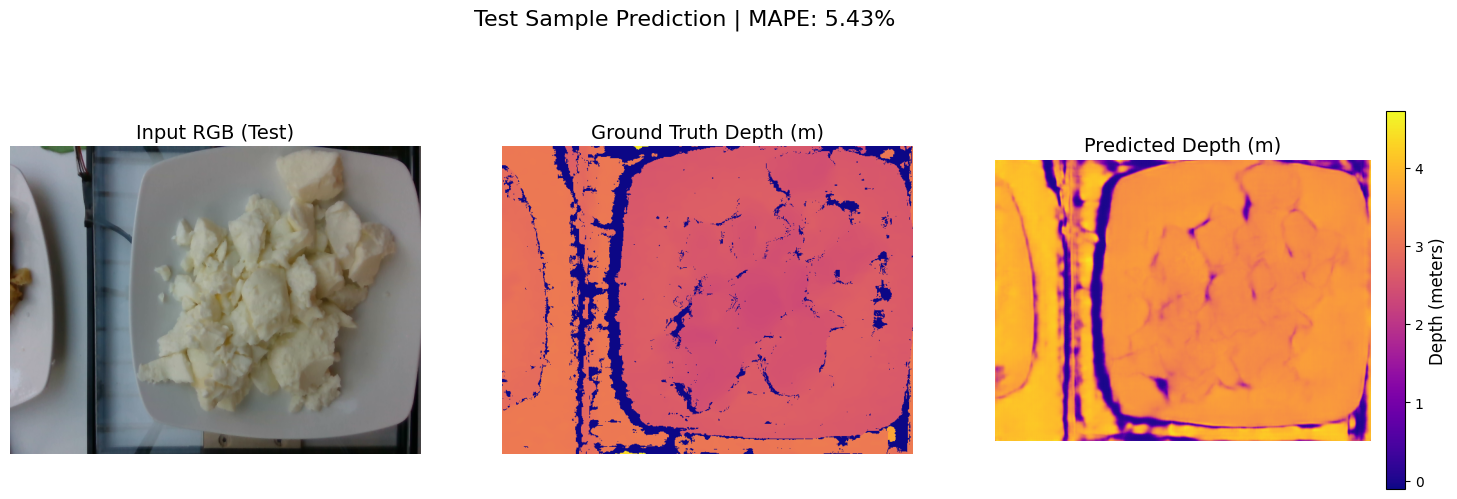

Figure saved: figures/test_prediction.png


In [17]:
# -------------------------------------------------
# BLOCK 8: Visualize One Test Sample
# -------------------------------------------------
print("Generating test sample visualization...")

model.eval()
rgb_batch, gt_batch = next(iter(test_loader))
rgb_batch, gt_batch = rgb_batch.to(device), gt_batch.to(device)

with torch.no_grad(), autocast('cuda'):
    pred_batch = model(rgb_batch)

# Move to CPU for plotting
rgb_np  = rgb_batch[0].cpu().numpy().transpose(1, 2, 0)
gt_np   = gt_batch[0].cpu().squeeze().numpy()
pred_np = pred_batch[0].cpu().squeeze().numpy()

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RGB
im0 = axes[0].imshow(rgb_np)
axes[0].set_title("Input RGB (Test)", fontsize=14)
axes[0].axis('off')

# Ground Truth
im1 = axes[1].imshow(gt_np, cmap='plasma')
axes[1].set_title("Ground Truth Depth (m)", fontsize=14)
axes[1].axis('off')

# Prediction
im2 = axes[2].imshow(pred_np, cmap='plasma')
axes[2].set_title("Predicted Depth (m)", fontsize=14)
axes[2].axis('off')

# FIXED COLORBAR: Use fig.colorbar with ax
cbar = fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_label('Depth (meters)', fontsize=12)

# Sample MAPE (with device safety)
sample_mape = mape(pred_batch[:1], gt_batch[:1]).item()
plt.suptitle(f"Test Sample Prediction | MAPE: {sample_mape:.2f}%", fontsize=16, y=0.98)

# Save for paper
Path('figures').mkdir(exist_ok=True)
plt.savefig('figures/test_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: figures/test_prediction.png")